## RESUMO do NOTEBOOK
---
* Processamento de Imagens com OpenCV
    * 'Masking'
    * Segmentação
    * Melhorar a Nitidez da Imagem
* Transfer Learning com modelos pré-treinados do Keras
* 'Feature Extraction'
* Modelo de Deep Learning com Redes Neurais para classificação de Imagens

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from tensorflow.keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Copiando modelos pré-treinados ao dirtório de cache

cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
    
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [3]:
# Copiar os modelos Xception para o diretório .keras/models (uma só vez)

In [4]:
base_folder = 'C:/JB/Repositorios/Fire_Detector'
data_folder = 'C:/JB\Repositorios/Fire_Detector/fire_dataset'
train_data_folder = 'C:/JB\Repositorios/Fire_Detector/fire_dataset/fire_images'
test_date_folder  = 'C:/JB\Repositorios/Fire_Detector/fire_dataset/non_fire_images'

categories = ['Imagens de Fogo', 'Imagens não-Fogo']
len_categories = len(categories)

In [6]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 334.30it/s]


In [7]:
# Verificando o número de imagens

for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

Imagens de Fogo -> 755
Imagens não-Fogo -> 244


In [8]:
# Criando um dataframe

df = pd.DataFrame(train_data, columns=['Arquivo', 'id', 'Rótulo'])
df.shape
df.head()

(999, 3)

,Arquivo,id,Rótulo
0,Imagens de Fogo/fire.1.png,0,Imagens de Fogo
1,Imagens de Fogo/fire.10.png,0,Imagens de Fogo
2,Imagens de Fogo/fire.100.png,0,Imagens de Fogo
3,Imagens de Fogo/fire.101.png,0,Imagens de Fogo
4,Imagens de Fogo/fire.102.png,0,Imagens de Fogo


###  PREPROCESSAMENTO de IMAGENS

In [9]:
# Função para 'masking'

def create_mask_for_plant(image):
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Função para segmentação da imagem

def segment_image(image):
    
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

# Função para afiar a imagem

def sharpen_image(image):
    
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# Função para captar a imagem

def read_img(filepath, size):
    
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    
    # Convertendo imagem para array
    img = image.img_to_array(img)
    return img

### MOSTRANDO EXEMPLOS de IMAGENS

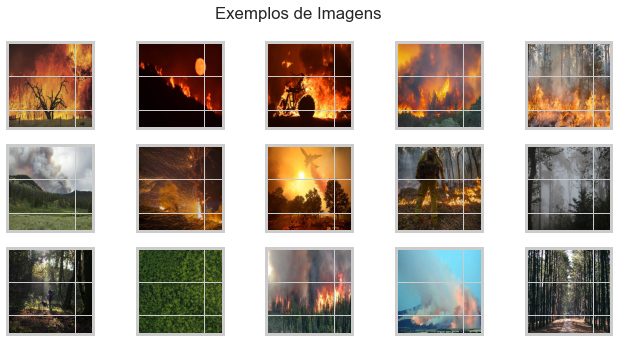

In [11]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('Exemplos de Imagens');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['Arquivo'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### MOSTRANDO EXEMPLOS de IMAGENS PREPROCESSADAS

<ipython-input-12-f6fee87a80fe>:19: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


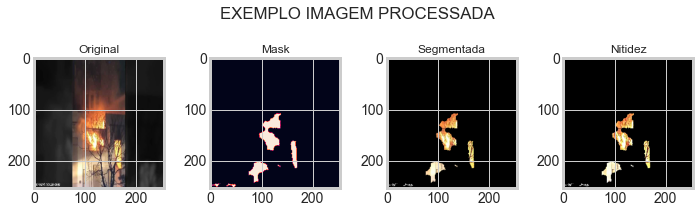

In [12]:
# Captando imagem

img = read_img(df['Arquivo'][102],(255,255))

# Mask

image_mask = create_mask_for_plant(img)

# Segmentação

image_segmented = segment_image(img)

# Nitidez

image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('EXEMPLO IMAGEM PROCESSADA', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('Original', fontsize=12)
ax[1].set_title('Mask', fontsize=12)
ax[2].set_title('Segmentada', fontsize=12)
ax[3].set_title('Nitidez', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);

### EXTRAÇÃO DE CARACTERÍSTICAS com XCEPTION

In [13]:
INPUT_SIZE=255

# Preprocessando a entrada

X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')

for i, file in tqdm(enumerate(df['Arquivo'])):
    
    # Ler imagem
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    
    # 'Masking' e segmentação
    image_segmented = segment_image(img)
    
    # Nitidez
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

999it [01:21, 12.32it/s]


In [14]:
print('Formato Imagem de Treino: ', X_train.shape)
print('Tamanho Imagem de Treino: ', X_train.size)

Formato Imagem de Treino:  (999, 255, 255, 3)
Tamanho Imagem de Treino:  194879925


#### Dividindo os Dados

In [15]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [16]:
print('Imagens de Fogo nos Dados de Treino: ',y_train[y_train==0].shape[0])
print('Imagens não-Fogo nos Dados de Treino: ',y_train[y_train==1].shape[0])

Imagens de Fogo nos Dados de Treino:  610
Imagens não-Fogo nos Dados de Treino:  189


In [17]:
# Captando as features (caraterísticas)

xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')

bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)

bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 16s 2s/step


In [18]:
print('Formato Treino: ', bf_train_x.shape)
print('Tamanho Treino: ', bf_train_x.size)

print('Formato Validação: ', bf_train_val.shape)
print('Tamanho Validação: ', bf_train_val.size)

Formato Treino:  (799, 2048)
Tamanho Treino:  1636352
Formato Validação:  (200, 2048)
Tamanho Validação:  409600


### MODELO DEEP LEARNING

In [19]:
# Keras Modelo Sequencial

model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Treinando o modelo com 100 epochs (varreduras)

history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 [==============================] - 4s 10ms/step - loss: 0.5432 - accuracy: 0.7635
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4745 - accuracy: 0.7635
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.4067 - accuracy: 0.8135
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3744 - accuracy: 0.8385
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3520 - accuracy: 0.8511
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3241 - accuracy: 0.8661
Epoch 7/100
25/25 [==============================] - 0s 4ms/step - loss: 0.3093 - accuracy: 0.8698
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2963 - accuracy: 0.8748
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2808 - accuracy: 0.8723
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 0.2532 - accuracy: 0.8974
Epoch 11

#### Função Perda (Erro) e Precisão

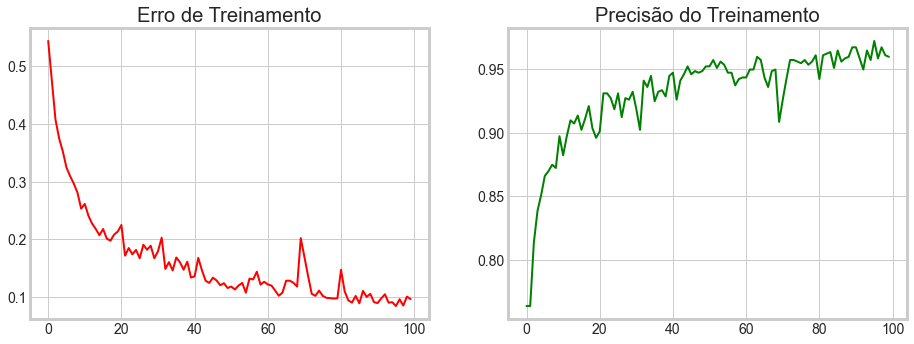

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('Erro de Treinamento');
ax[1].set_title('Precisão do Treinamento');


ax[0].plot(history.history['loss'], color= 'red',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [22]:
# Predições nos Dados de Validação

predictions = model.predict(bf_train_val)

In [35]:
# Verificando formato (Variável Inteira Binária - Classificação)

y_val[5:10]

604    0
246    0
827    1
801    1
513    0
Name: id, dtype: int64

In [32]:
# Verificando formato (Array de Floats)

predictions[:5]

array([[1.9703617e-07],
       [4.9775839e-04],
       [7.2317434e-06],
       [2.3919622e-06],
       [6.2271502e-05]], dtype=float32)

#### 'CLASSIFICATION REPORT'

In [31]:
# Ambas variáveis devem ser inteiras...

print(classification_report(y_val, predictions.astype(int), zero_division=1))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       145
           1       1.00      0.00      0.00        55

    accuracy                           0.73       200
   macro avg       0.86      0.50      0.42       200
weighted avg       0.80      0.72      0.61       200



#### MATRIZ de CONFUSÃO

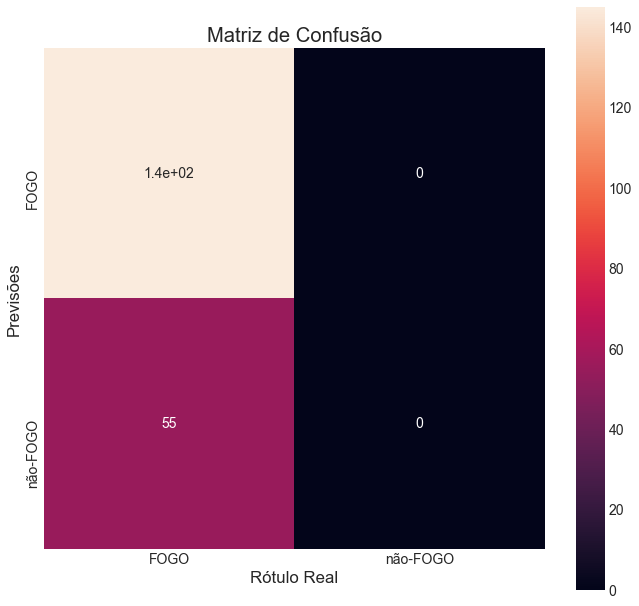

In [28]:
confusion_mat = confusion_matrix(y_val, predictions.astype(int))

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FOGO', 'não-FOGO'],
            xticklabels=['FOGO', 'não-FOGO']);
plt.title('Matriz de Confusão');
plt.xlabel('Rótulo Real');
plt.ylabel("Previsões");